# Strategy Performance Dashboard
Interactive evaluation of signals and trading strategy.

## 1. Load Signal Log

In [18]:
import pandas as pd
import numpy as np

df = pd.read_csv("../logs/signals.csv", parse_dates=["time"])
df = df.sort_values("time")
df.tail()

,time,close,rsi_14,signal
6,2025-06-05 03:50:00,318.09,41.712204,0
7,2025-06-05 03:55:00,317.81,36.528029,0
8,2025-06-05 04:00:00,318.08,44.298246,0
9,2025-06-05 04:05:00,317.90,47.417840,0
10,2025-06-05 04:10:00,317.91,56.511628,0


## 2. Define Future Returns and True Actions

In [19]:
df["future_return"] = df["close"].pct_change().shift(-1)
df["true_action"] = 0
df.loc[df["future_return"] > 0.001, "true_action"] = 1
df.loc[df["future_return"] < -0.001, "true_action"] = -1
df["correct"] = df["signal"] == df["true_action"]


## 3. Classification Report & Metrics

In [22]:
from sklearn.metrics import classification_report

print(classification_report(df["true_action"], df["signal"], labels=[1, 0, -1], zero_division=0))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           0       0.70      1.00      0.82         7
          -1       1.00      0.33      0.50         3

    accuracy                           0.73        11
   macro avg       0.57      0.44      0.44        11
weighted avg       0.72      0.73      0.66        11



## 4. Confusion Matrix Visualization

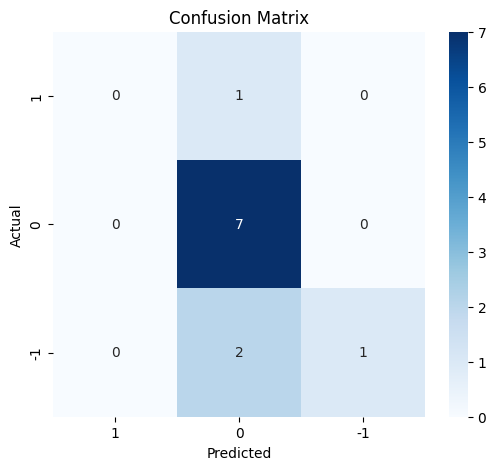

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(df["true_action"], df["signal"], labels=[1, 0, -1])
labels = [1, 0, -1]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## 5. Plot Rolling Strategy Accuracy

<Axes: title={'center': 'Rolling Accuracy (window=50)'}, xlabel='time'>

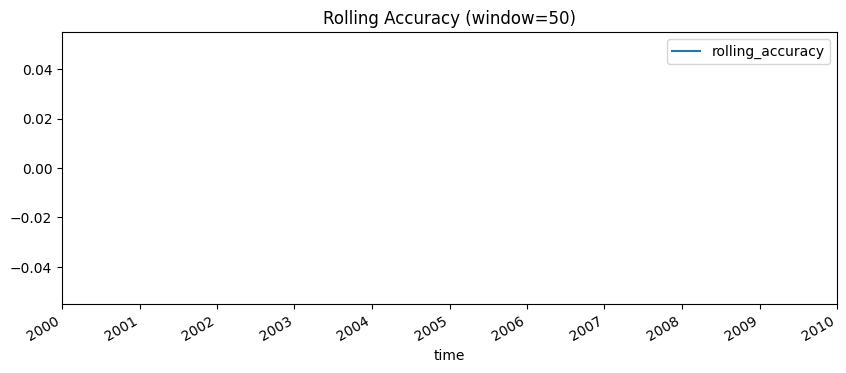

In [24]:
df["rolling_accuracy"] = df["correct"].rolling(50).mean()
df[df["time"] >= "2018-01-01"][["time", "rolling_accuracy"]].plot(x="time", title="Rolling Accuracy (window=50)", figsize=(10, 4))


## 6. Cumulative Strategy Return Simulation

<Axes: title={'center': 'Cumulative Return: Strategy vs Market'}, xlabel='time'>

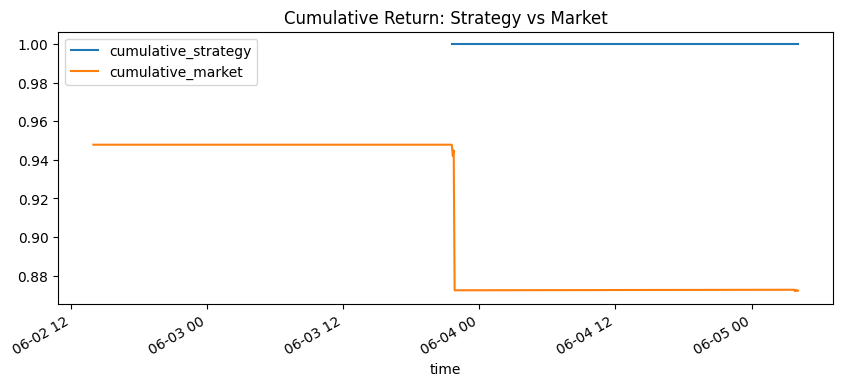

In [25]:
df["strategy_return"] = df["future_return"] * df["signal"].shift(1)
df["cumulative_strategy"] = (1 + df["strategy_return"]).cumprod()
df["cumulative_market"] = (1 + df["future_return"]).cumprod()

df.set_index("time")[["cumulative_strategy", "cumulative_market"]].plot(title="Cumulative Return: Strategy vs Market", figsize=(10, 4))


## 7. Profit Per Trade Distribution

Text(0.5, 1.0, 'Strategy Return per Signal')

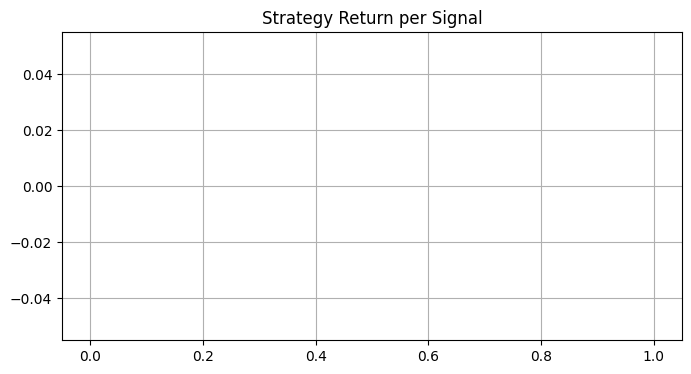

In [26]:
profits = df.loc[df["signal"] != 0, "strategy_return"]
ax = profits.hist(bins=50, figsize=(8, 4))
plt.title("Strategy Return per Signal")


## 8. Optional: Export Summary Stats

In [27]:
summary = {
    "accuracy": df["correct"].mean(),
    "total_signals": len(df[df["signal"] != 0]),
    "profitable_signals": (profits > 0).sum(),
    "mean_profit_per_trade": profits.mean()
}
pd.DataFrame([summary])


,accuracy,total_signals,profitable_signals,mean_profit_per_trade
0,0.727273,1,0,NaN
